# Housing Data Exploratory Data Analysis
## Summary
- Data was webscraped from the Invitation Homes website and stored in a single .parquet file. 
- The data available is the data scraped from 2022-06-12 to 2023-03-27. There are decent chunks of time where data was not scraped.
- Data is timestamped for when the data was scraped. Therefore the same listing would be listed multiple times, often at different prices.
- Invitation Homes doesn't rent houses in all states and cities. The data is only representative of their portfolio.

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import json

import plotly.io as pio
pio.renderers.default='notebook'

RAW_DATA_PATH = "data/raw/housing_data.parquet"

In [2]:
rental_df = pd.read_parquet(RAW_DATA_PATH)
rental_df.head()

,id,unit_code,property_code,market_id,market_name,address_1,address_2,city,state,zipcode,...,submarket_names,subdivision,bid_type,asset_review_type,days_on_market,formattedAddress,date,has_virtual_tour,btr_community,model_home
0,41b87620-08b5-46e9-8f8c-9687d52ed977,10044306,10044306,09a94bc5-b6f6-4621-960f-0198750adb80,Southern California,1238 W 55Th St,None,Los Angeles,CA,90037.0,...,LA Metro West,None,Trustee,None,0,"1238 W 55Th St\nLos Angeles, CA 90037",2022-06-12 22:51:48,None,None,None
1,98bd5caa-1717-4398-a66d-b1a5452cba1b,10050818,10050818,09a94bc5-b6f6-4621-960f-0198750adb80,Southern California,8947 S Denker Ave,None,Los Angeles,CA,90047.0,...,LA Metro West,None,Standard Sale,RevEx,9,"8947 S Denker Ave\nLos Angeles, CA 90047",2022-06-12 22:51:48,None,None,None
2,ff6c3e1c-0667-4613-bb42-f77a499cf7c7,10080427,10080427,09a94bc5-b6f6-4621-960f-0198750adb80,Southern California,8916 David Ave,None,Los Angeles,CA,90034.0,...,LA Metro West,None,Trustee,None,0,"8916 David Ave\nLos Angeles, CA 90034",2022-06-12 22:51:48,None,None,None
3,42dbbad0-884b-457d-bde4-6508f8d943a5,10080549,10080549,09a94bc5-b6f6-4621-960f-0198750adb80,Southern California,636 N Lamer St,None,Burbank,CA,91506.0,...,San Fernando Valley East,None,Standard Sale,None,0,"636 N Lamer St\nBurbank, CA 91506",2022-06-12 22:51:48,None,None,None
4,494a5455-db37-4d66-a67f-e8c780c4095e,10060373,10060373,09a94bc5-b6f6-4621-960f-0198750adb80,Southern California,11063 Kittridge St,None,North Hollywood,CA,91606.0,...,San Fernando Valley East,None,Standard Sale,None,0,"11063 Kittridge St\nNorth Hollywood, CA 91606",2022-06-12 22:51:48,None,None,None


In [3]:
len(rental_df)

558806

## Columns
- Many columns weren't filled out for each listing resulting in missing data. Many columns also don't seem very useful.
- The columns most useful for data analysis are listed
- Some notes were added for the useful columns
### Useful Columns
- `id` seems to be the UUID used by the website to track each listing. Repeats of the same id on different dates could be used to track changes in the listing pricing
- `market_name` can correspond to different cities or states. The lack of consistency makes this less useful than `city` or `state`
- `address_1` is the address of the listing. `address_2` doesn't  seem to be used.
- `city`
- `state` is the two letter abreviation of the state
- `zipcode`
- `country` is not actually useful because it is all in the USA
- `beds`
- `baths`
- `sqft`
- `market_rent`
- `submarket_names` is more specific than `market_name`. It is likely that internally, Invitation Homes uses these two to catergorize their properties and markets.
- `subdivision` seems to be the suburb subdivision. It is a even more specific than zip codes.
- `days_on_market`
- `date` important custom column. This was the timestamp when the data was scraped.

In [4]:
rental_df.columns

Index(['id', 'unit_code', 'property_code', 'market_id', 'market_name',
       'address_1', 'address_2', 'city', 'state', 'zipcode', 'country', 'beds',
       'baths', 'sqft', 'market_rent', 'lat', 'lng', 'available_at', 'unit_id',
       'unit_status', 'is_syndicated', 'is_syndicated_ils', 'is_on_special',
       'new_construction', 'est_rehab_complete_date', 'rehab_type',
       'submarket_names', 'subdivision', 'bid_type', 'asset_review_type',
       'days_on_market', 'formattedAddress', 'date', 'has_virtual_tour',
       'btr_community', 'model_home'],
      dtype='object')

In [5]:
# rental_df["market_name"].value_counts()
# rental_df["address_1"].value_counts()
# rental_df["address_2"].value_counts()
# rental_df["city"].value_counts()
# rental_df["state"].value_counts()
# rental_df["zipcode"].value_counts()
# rental_df["country"].value_counts()
# rental_df["submarket_names"].value_counts()
# rental_df["subdivision"].value_counts()

rental_df[["market_name", "address_1", "address_2", "city", "state", "zipcode", "country", "submarket_names", "subdivision"]].astype(str).describe().transpose()

,count,unique,top,freq
market_name,558806,16,Phoenix,82787
address_1,558806,19207,6412 La Plata Peak Dr,241
address_2,558806,1,None,558806
city,558806,869,Colorado Springs,20040
state,558806,12,FL,161598
zipcode,558806,1753,80817.0,7394
country,558806,1,US,558806
submarket_names,558806,228,Colorado Springs,27434
subdivision,558806,5207,None,334944


In [6]:
rental_df[["beds", "baths", "sqft", "days_on_market"]].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
beds,558806.0,3.50,0.63,1.00,3.0,3.0,4.0,7.0
baths,558806.0,2.33,0.49,0.25,2.0,2.0,2.5,7.0
sqft,558806.0,1905.51,497.47,180.00,1554.0,1828.0,2178.0,7928.0
days_on_market,558806.0,11.05,23.47,-1.00,0.0,0.0,13.0,3306.0


In [7]:
rental_df[['available_at', 'unit_id',
       'unit_status', 'is_syndicated', 'is_syndicated_ils', 'is_on_special',
       'new_construction', 'est_rehab_complete_date', 'rehab_type',
       'bid_type', 'asset_review_type',
       'formattedAddress', 'has_virtual_tour',
       'btr_community', 'model_home']].astype(str).describe(include="all", datetime_is_numeric=True).transpose()

,count,unique,top,freq
available_at,558806,474,2022-08-15T00:00:00.000Z,6904
unit_id,558806,19197,90252,241
unit_status,558806,3,Vacant Unrented Ready,221929
is_syndicated,558806,2,True,558647
is_syndicated_ils,558806,2,True,514400
is_on_special,558806,2,False,545211
new_construction,558806,2,False,553973
est_rehab_complete_date,558806,416,None,212907
rehab_type,558806,6,Turn,424522
bid_type,558806,7,Standard Sale,232876


In [8]:
# A decent number of coordinates are missingd
# rental_df[["lat", "lng"]].value_counts()
rental_df["lat"].isna().sum()
# rental_df[rental_df["lat"].isna()]

218486

In [9]:
# rental_df["date"].value_counts()
initial_date = rental_df["date"].iloc[0]
last_date = rental_df["date"].iloc[-1]

print(f"Initial date: {initial_date}\nLast date: {last_date}")

# corresponds to how much data was scraped for a given day
rental_df["date"].value_counts()

Initial date: 2022-06-12 22:51:48
Last date: 2023-03-27 07:07:32.904720


2022-09-12 07:34:37.000000    2997
2022-09-19 07:45:57.083464    2989
2022-09-07 17:25:48.000000    2971
2022-09-09 07:32:09.000000    2970
2022-09-10 11:37:46.000000    2969
                              ... 
2023-02-24 06:41:32.153726    1439
2023-02-23 06:55:55.856129    1439
2023-01-25 06:47:25.989641    1421
2023-01-27 06:43:46.307222    1418
2023-01-26 06:41:47.380112    1404
Name: date, Length: 252, dtype: int64

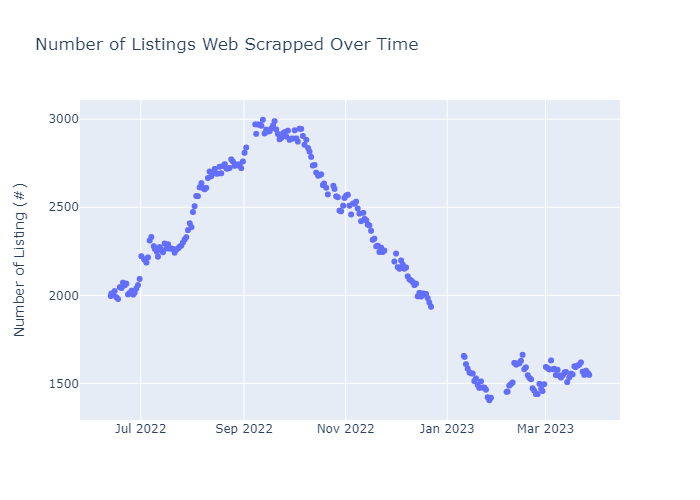

In [11]:
date_listing_count = rental_df['date'].value_counts()

# Count of listings for each date. Tracks how much data and what days are covered by the data set
# There are some gaps in the data because I didn't feel like it
fig = go.Figure(
    go.Scatter(
        x= date_listing_count.index,
        y= date_listing_count.values,
        mode= 'markers'
    )
)

fig.update_layout(
    yaxis_title = 'Number of Listing (#)',
    title = "Number of Listings Web Scrapped Over Time"
)

fig.show(renderer="png")